In [24]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
plt.style.use('ggplot')

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
# CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 1
MAX_CAREER_LENGTH_COHORT = 15
END_YEAR = 2018

num_years_in_cohort = 3
#print(calculate.cliffsD([1, 2, 3, 4, 5, 9], [1, 2, 5, 6, 7, 9]))

## Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

### Read authors with start and end year details

In [2]:
# authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-extended.csv')
authorStartEndCareerData.head()

,author,start_year,end_year,total_num_pub,career_length,gender,early_career_degree_1,early_career_degree_2,early_career_degree_3,early_career_degree_4,...,early_career_prod_5,max_absence-0-15,avg_absence-0-15,max_absence-0-3,avg_absence-0-3,max_absence-4-9,avg_absence-4-9,max_absence-10-15,avg_absence-10-15,dropped_after_10
0,'maseka lesaoana,2001,2015,2,15,none,0.0,0.0,0.0,0.0,...,1,14,5.0,3,1.5,6.0,6.0,4.0,2.5,True
1,(max) zong-ming cheng,2009,2011,2,3,none,11.0,11.0,14.0,16.0,...,2,13,5.0,2,1.0,6.0,6.0,6.0,6.0,True
2,(zhou) bryan bai,2011,2012,2,2,none,0.0,0.0,0.0,0.0,...,2,14,5.0,2,1.0,6.0,6.0,6.0,6.0,True
3,a aart blokhuis,1992,2005,2,14,none,0.0,0.0,0.0,0.0,...,1,13,5.0,3,1.5,6.0,6.0,3.0,2.5,True
4,a ahrabian,2017,2017,1,1,none,0.0,0.0,0.0,0.0,...,1,15,7.5,3,1.5,6.0,6.0,6.0,6.0,True


#### Career len removal

In [3]:
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData.career_length >= CAREER_LENGTH]

### Read Citation data (uses paper->author network)

In [4]:
# authorCitationsData = pd.read_csv('derived-data/authors-perYear-citations-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorCitationsData = pd.read_csv('derived-data/authors-perYear-citations.csv')
authorCitationsData.rename(columns={'year_cit':'year', 'cit_count':'num_cit'}, inplace=True)

#### Tests

In [5]:
# 'maseka lesaoana published 2 publications in total, one in 2001 and one in 2015
# for the one is 2015 she did not get yet any citations
authorCitationsData[authorCitationsData["author"] == "'maseka lesaoana"]

,author,year,num_cit
0,'maseka lesaoana,2002,1
1,'maseka lesaoana,2003,1
2,'maseka lesaoana,2004,1
3,'maseka lesaoana,2005,2
4,'maseka lesaoana,2006,4
5,'maseka lesaoana,2007,1
6,'maseka lesaoana,2008,3
7,'maseka lesaoana,2009,1
8,'maseka lesaoana,2010,1
9,'maseka lesaoana,2012,1


In [6]:
authorStartEndCareerData[authorStartEndCareerData["author"] == "'maseka lesaoana"]

,author,start_year,end_year,total_num_pub,career_length,gender,early_career_degree_1,early_career_degree_2,early_career_degree_3,early_career_degree_4,...,early_career_prod_5,max_absence-0-15,avg_absence-0-15,max_absence-0-3,avg_absence-0-3,max_absence-4-9,avg_absence-4-9,max_absence-10-15,avg_absence-10-15,dropped_after_10
0,'maseka lesaoana,2001,2015,2,15,none,0.0,0.0,0.0,0.0,...,1,14,5.0,3,1.5,6.0,6.0,4.0,2.5,True


In [7]:
# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
authorCitationsData[authorCitationsData["author"] == '(max) zong-ming cheng']

,author,year,num_cit
14,(max) zong-ming cheng,2009,1
15,(max) zong-ming cheng,2010,2
16,(max) zong-ming cheng,2013,1


### Merge citations with authors

In [9]:
authorCitationsData = authorCitationsData.merge(authorStartEndCareerData[['author', 'start_year', 'gender']], on='author')

### Citation distribution after 15 years

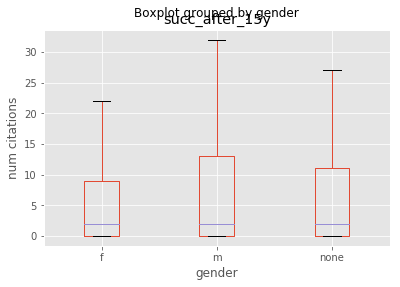

In [10]:
ax = authorStartEndCareerData.boxplot(column='succ_after_15y', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

# Cohort Analysis on all authors for 15 years

#### Select Cohorts based on Start Years

In [11]:
groupByYearData = calculate.calculate_cumulative_for_authors(authorCitationsData, 'num_cit')

In [12]:
groupByYearData.shape

(6967113, 6)

In [13]:
years = groupByYearData['year'].unique()
years = sorted(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]



In [17]:
from importlib import reload
reload(plot)
reload(calculate)

<module 'calculate' from '/home/danielkostic/cumulative-advantage/calculate.py'>

#### Tests

In [ ]:
# some plausibility checks
print(groupByYearData.head(n=1))
print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))

# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
# in 2011 he received 0 citations and after 2013 as well!!!
print(groupByYearData[groupByYearData["author"] == '(max) zong-ming cheng'])

### Cohort Analysis (Num Cit)

get_cohort_careerage_df
plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


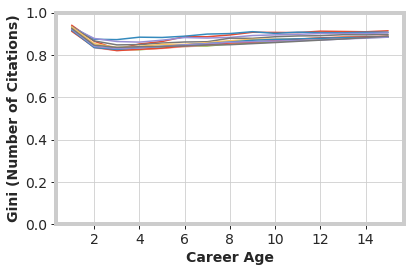

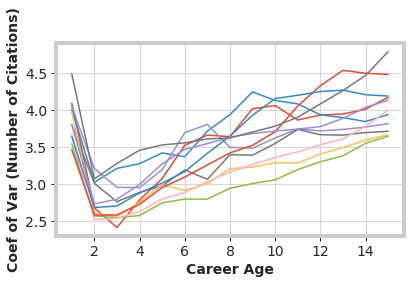

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


plot_cohort_means_over_ages


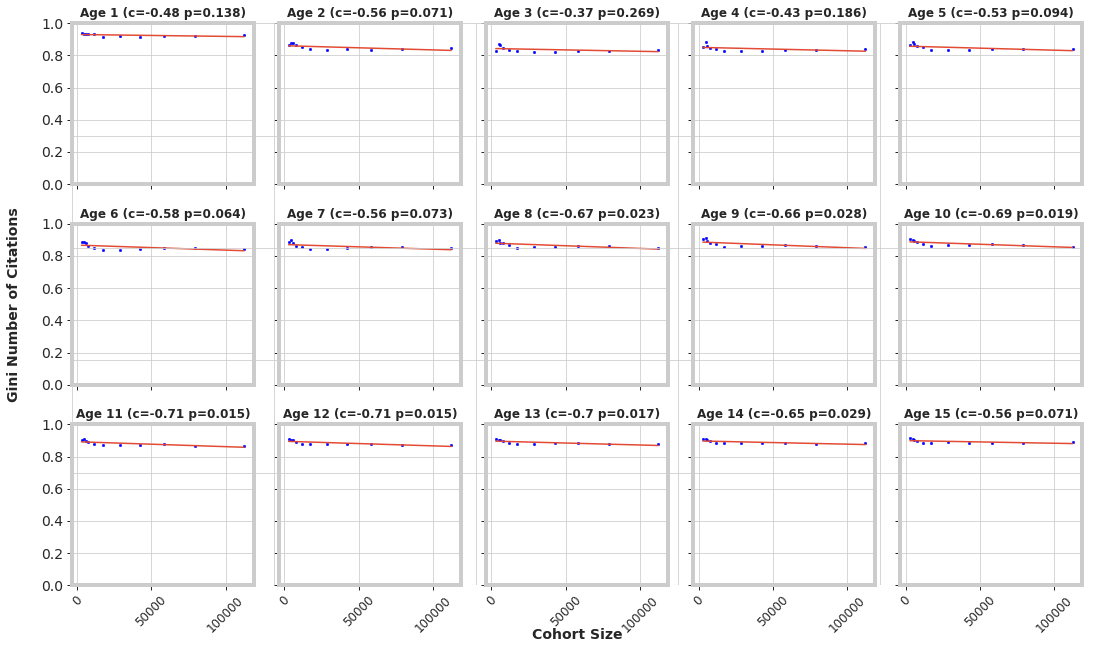

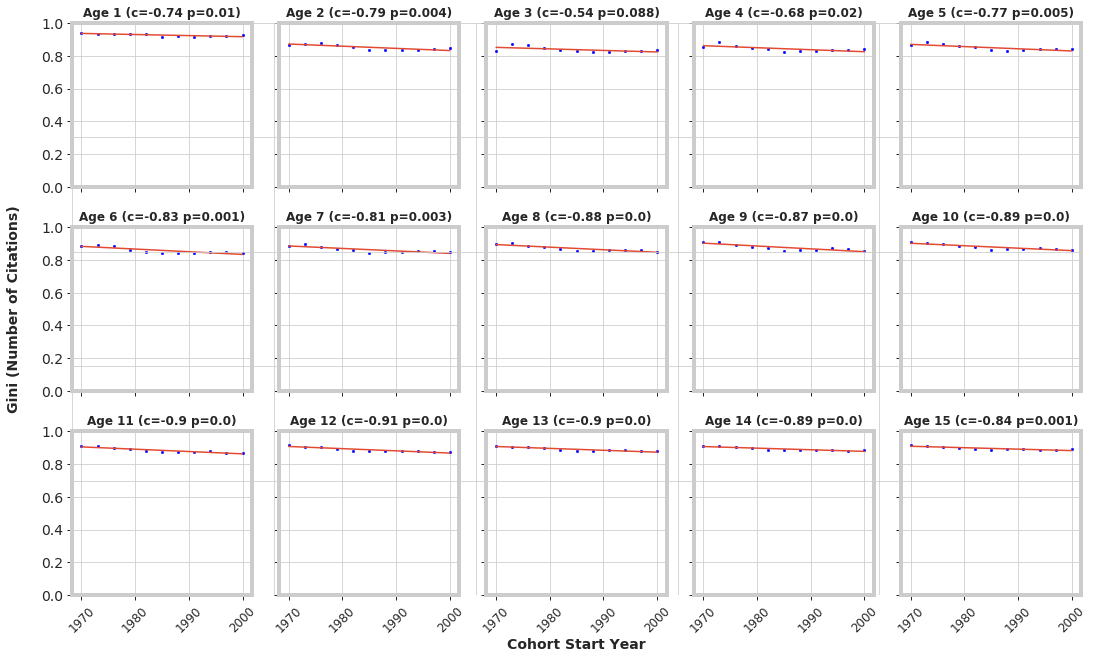

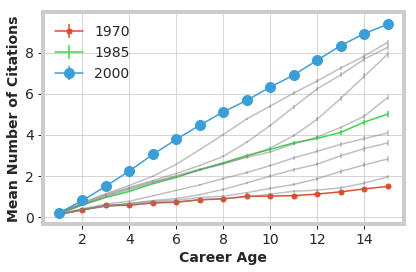

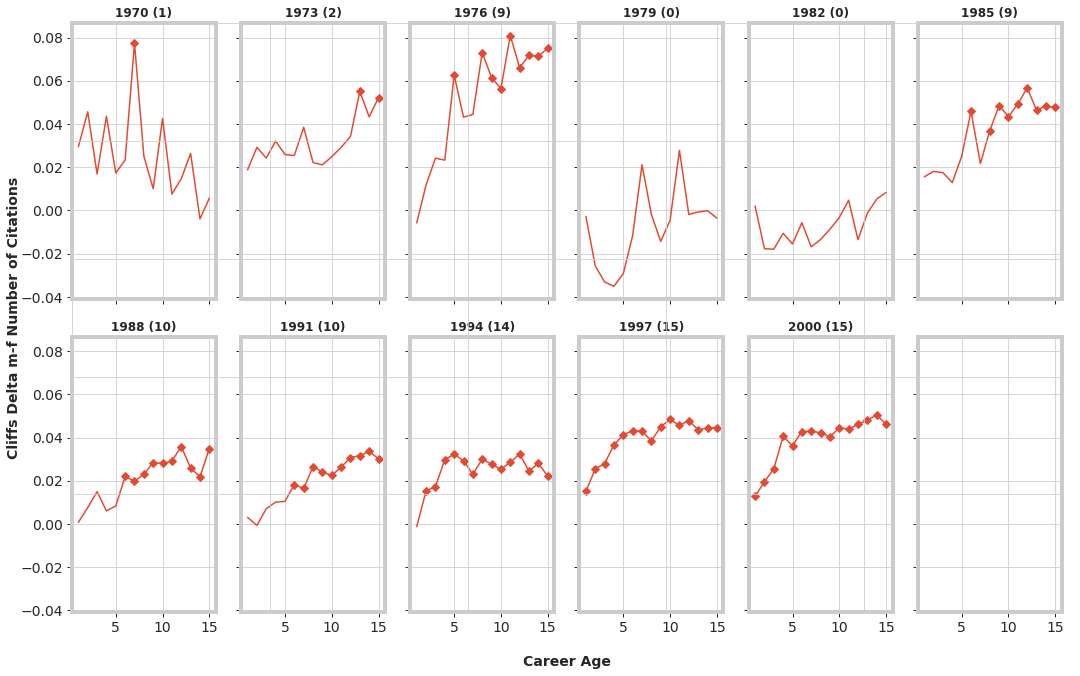

In [25]:
plot.run_cohort_analysis(authorCitationsData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_cit", 
                         "Number of Citations", authorStartEndCareerData, num_years_in_cohort)  

### Effect size - TODO

In [ ]:
groupByYearData, cohort_start_years, max_career_age_cohort, criterion, criterion_display, authorStartEndCareerData, skip_overlaping_years = authorCitationsData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_cit", "Number of Citations", authorStartEndCareerData, skip_overlaping_years

In [ ]:
cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, max_career_age_cohort, criterion, authorStartEndCareerData, skip_overlaping_years)

In [ ]:
effect_formula = ['r', 'common_language']

In [ ]:
cohort_effect_size = plot.get_cohort_effect_size(cohort_careerage_df, 'm', 'f', effect_formula[0])
plot.plot_cohort_effect_size(cohort_effect_size, num_significant = 10, effect_formula = effect_formula[0])

In [ ]:
cohort_effect_size.head()

In [ ]:
cohort_effect_size = plot.get_cohort_effect_size(cohort_careerage_df, 'm', 'f', effect_formula[1])
plot.plot_cohort_effect_size(cohort_effect_size, num_significant = 10, effect_formula = effect_formula[1])

#### Tests

In [ ]:
from importlib import reload
reload(plot)

cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, 
                                                   "cum_num_cit", authorStartEndCareerData)

#------------------------------------------

In [ ]:
cohort_careerage_df.head()

In [ ]:
subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & 
                              (cohort_careerage_df.gender == "all")]
vals1 = subset1["values"]

subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & 
                               (cohort_careerage_df.gender == "all")]
vals10 = subset10["values"]

from collections import Counter

print(type(vals1))
print(Counter(vals1.values[0]))
print(len(vals1.values[0]))


print(type(vals10))
print(Counter(vals10.values[0]))
print(len(vals10.values[0]))

### Cohort Analysis (Cum Num Cit)

get_cohort_careerage_df
plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


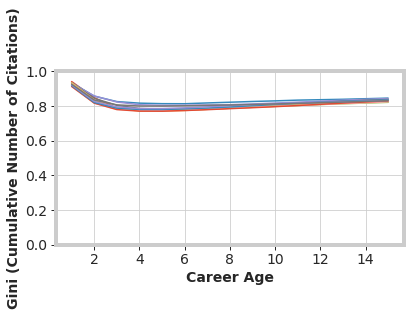

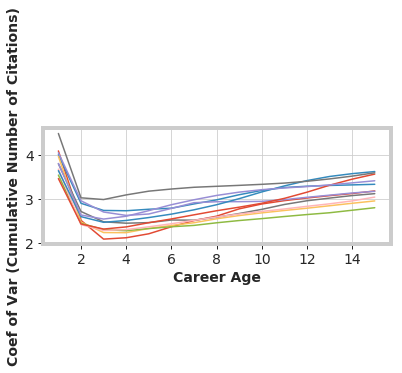

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


plot_cohort_means_over_ages


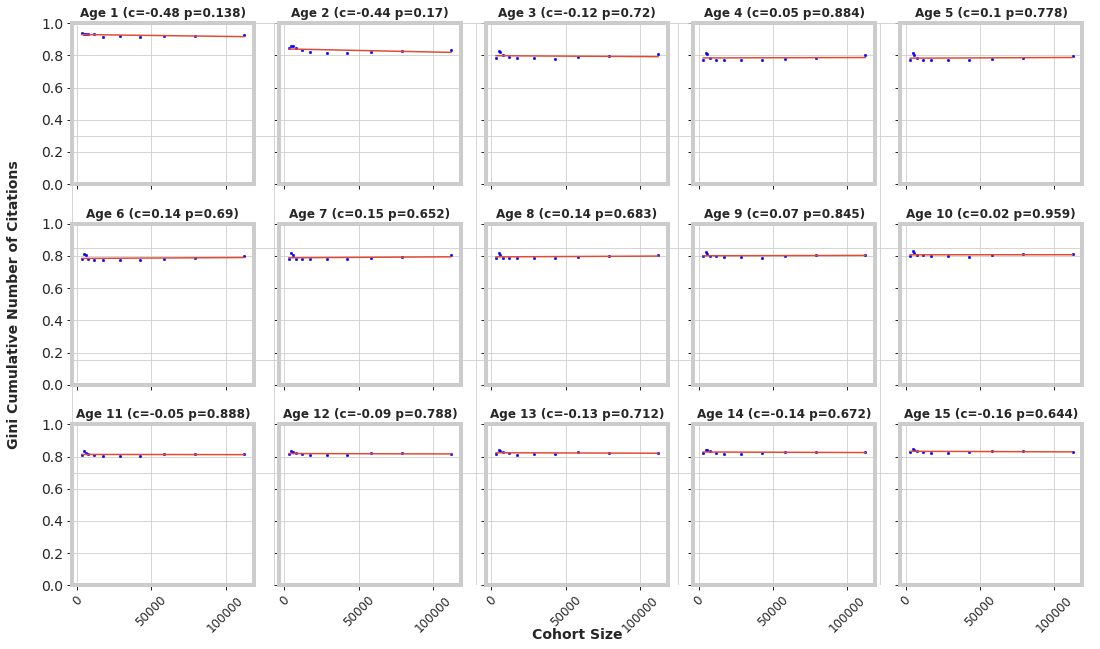

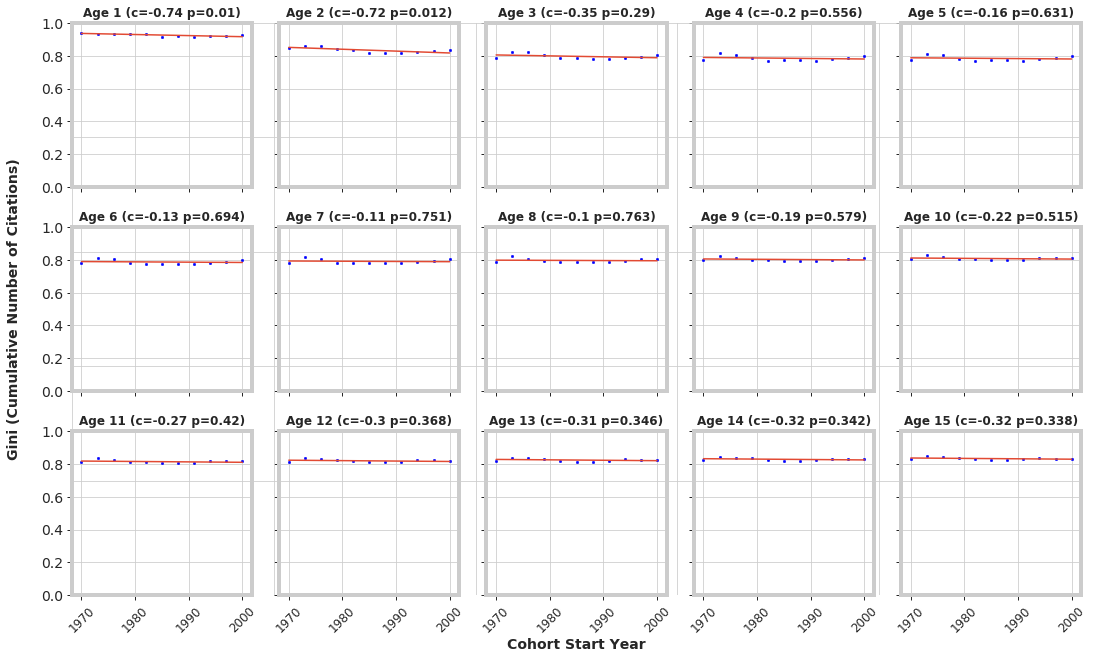

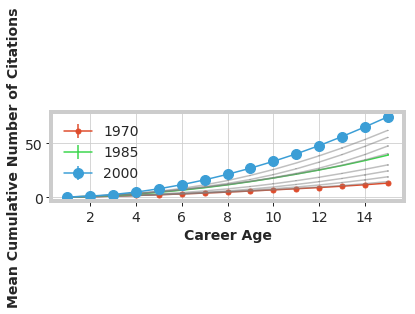

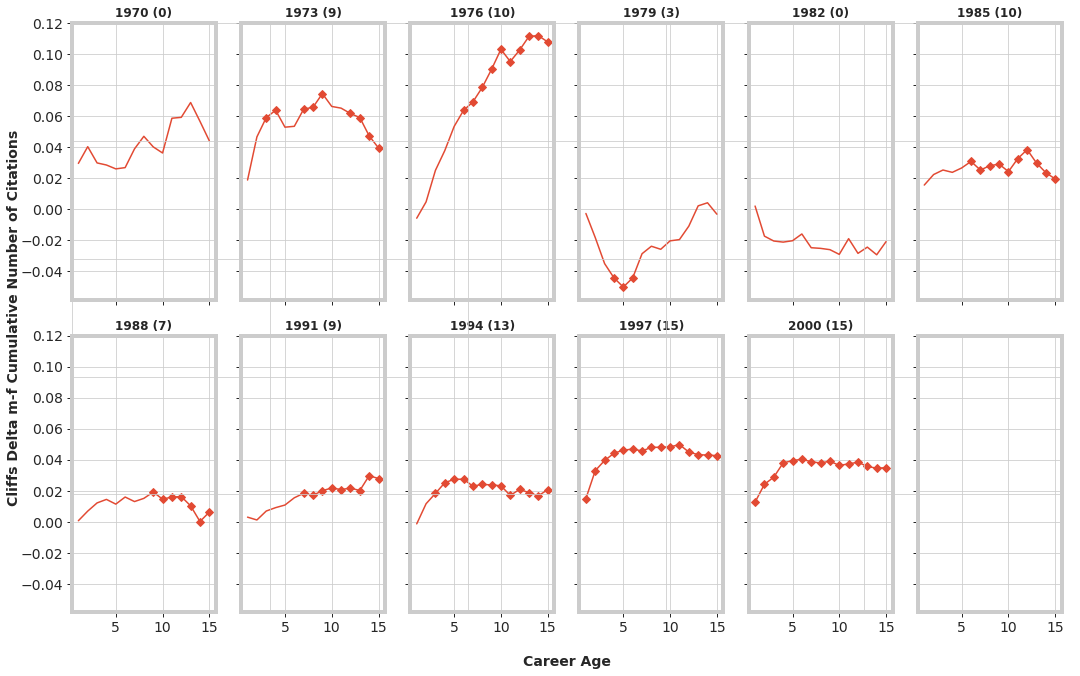

In [26]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, 
                         MAX_CAREER_LENGTH_COHORT, "cum_num_cit", "Cumulative Number of Citations", authorStartEndCareerData,num_years_in_cohort)  

# What should i do with the rest of this notebook?

### Cumulative Distributions for Selected Cohorts and Career Ages

how do these distributions differ?

In [ ]:
# cohort_start_years = [1974, 1975, 1976, 1979, 2000]

# cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'num_cit')
# plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_cit', 'Number of Citations')

# cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'cum_num_cit')
# plot.plot_cumulative_dist(cohort_careerage_df, 1, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 5, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'cum_num_cit', 'Cumulative Number of Citations')

### Why is there a sudden increase in mean citation count for cohort started in 1985?

In [ ]:
# _1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1975] 
# _1985Authors.shape

In [ ]:
# _1985Authors.columns

In [ ]:
# _1985Authors.sort_values(by=['num_cit'], axis = 0, ascending=False,inplace=False)

In [ ]:
# _1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
# _1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
# print(_1995_2000_year_1985Authors.shape)
# _1995_2000_year_1985Authors.head(10)

In [ ]:
# temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
# temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
# temp.head()

# #print(temp1['id2'].unique())

In [ ]:
# donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
# donatella

In [ ]:
# plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [ ]:
# authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

In [ ]:
reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

In [ ]:
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)